In [1]:
import cv2
import numpy as np
from skimage import feature
from matplotlib import pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os

In [3]:
# Load image with error handling
img_path = 'picture.jpg'
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image file not found: {img_path}")

try:
    image = cv2.imread(img_path)
    if image is None:
        raise ValueError("Image format is not supported or image is corrupted.")
except Exception as e:
    print(f"Error loading image: {e}")
    exit()

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [4]:
# 1. Color Histogram
color_histogram = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
color_histogram = cv2.normalize(color_histogram, color_histogram).flatten()

In [5]:
# 2. Edge Detection (Canny)
edges = cv2.Canny(gray_image, 100, 200)

In [6]:
# 3. Texture Features (Local Binary Pattern)
lbp = feature.local_binary_pattern(gray_image, P=8, R=1, method='uniform')
n_bins = int(lbp.max() + 1)
lbp_histogram, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))

In [20]:
# 4. Shape Features (Contour Detection)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [21]:
# 5. Keypoint Detection (ORB)
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(gray_image, None)

In [22]:
# 6. Deep Learning Features (ResNet)
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [23]:
# Preprocess the image
img = Image.open(img_path)
img_tensor = preprocess(img).unsqueeze(0)

In [24]:
# Extract deep features
with torch.no_grad():
    deep_features = model(img_tensor)
deep_features_np = deep_features.squeeze().numpy()

In [25]:
# Display results
plt.figure(figsize=(12, 12))

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

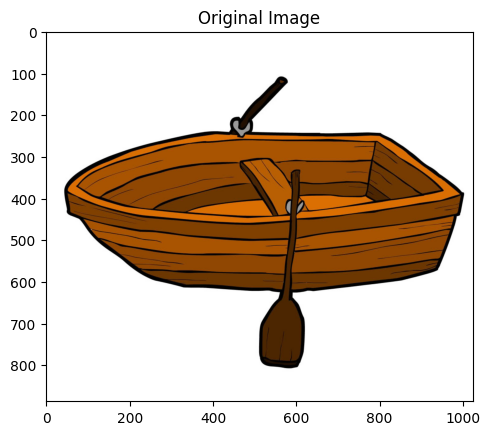

In [26]:
plt.subplot(1, 1, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

<BarContainer object of 512 artists>

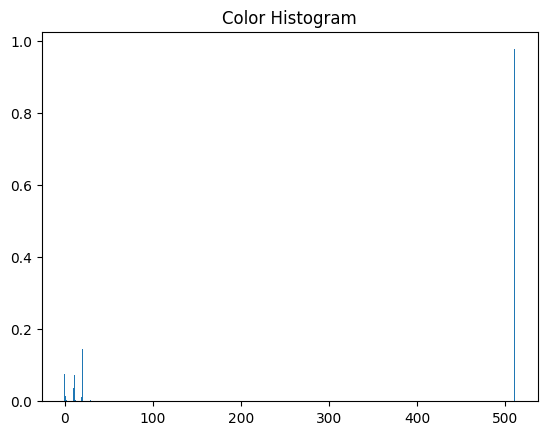

In [28]:
plt.subplot(1, 1, 1)
plt.title('Color Histogram')
plt.bar(range(len(color_histogram)), color_histogram)

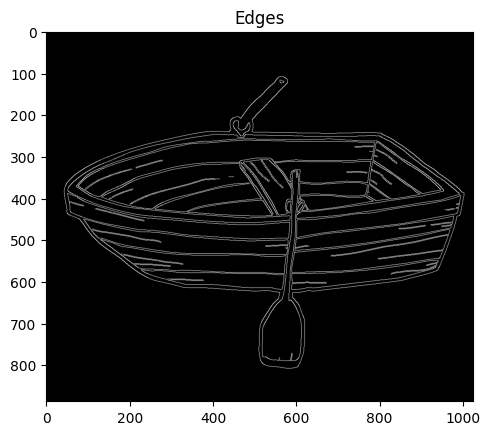

In [30]:
plt.subplot(1, 1, 1)
plt.title('Edges')
plt.imshow(edges, cmap='gray')

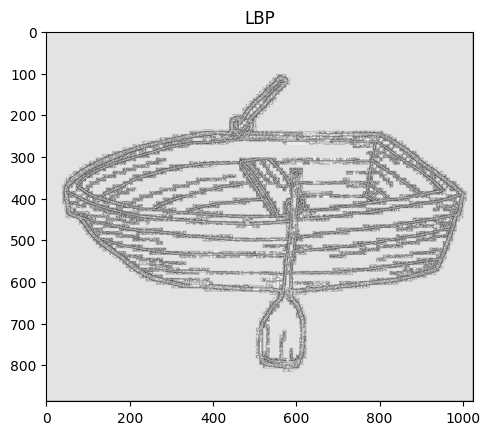

In [31]:
plt.subplot(1, 1, 1)
plt.title('LBP')
plt.imshow(lbp, cmap='gray')

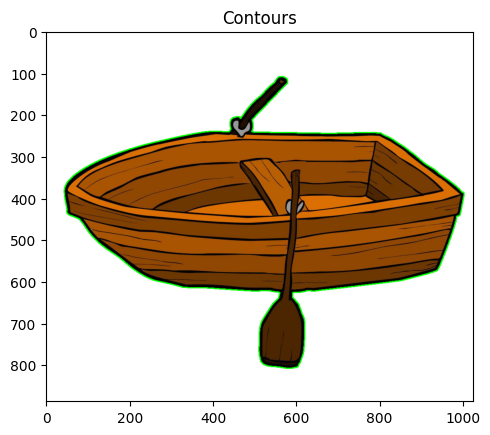

In [33]:
plt.subplot(1, 1, 1)
plt.title('Contours')
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))

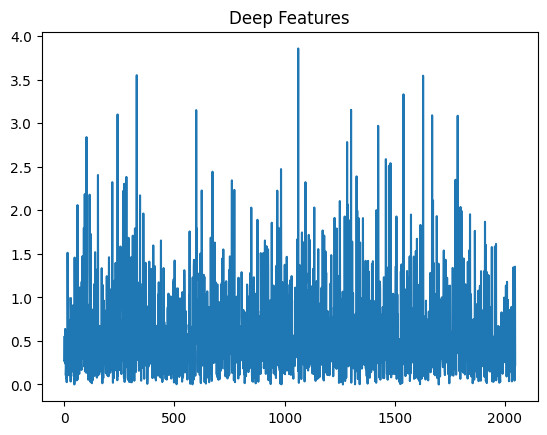

In [35]:
plt.subplot(1, 1, 1)
plt.title('Deep Features')
plt.plot(deep_features_np.flatten())

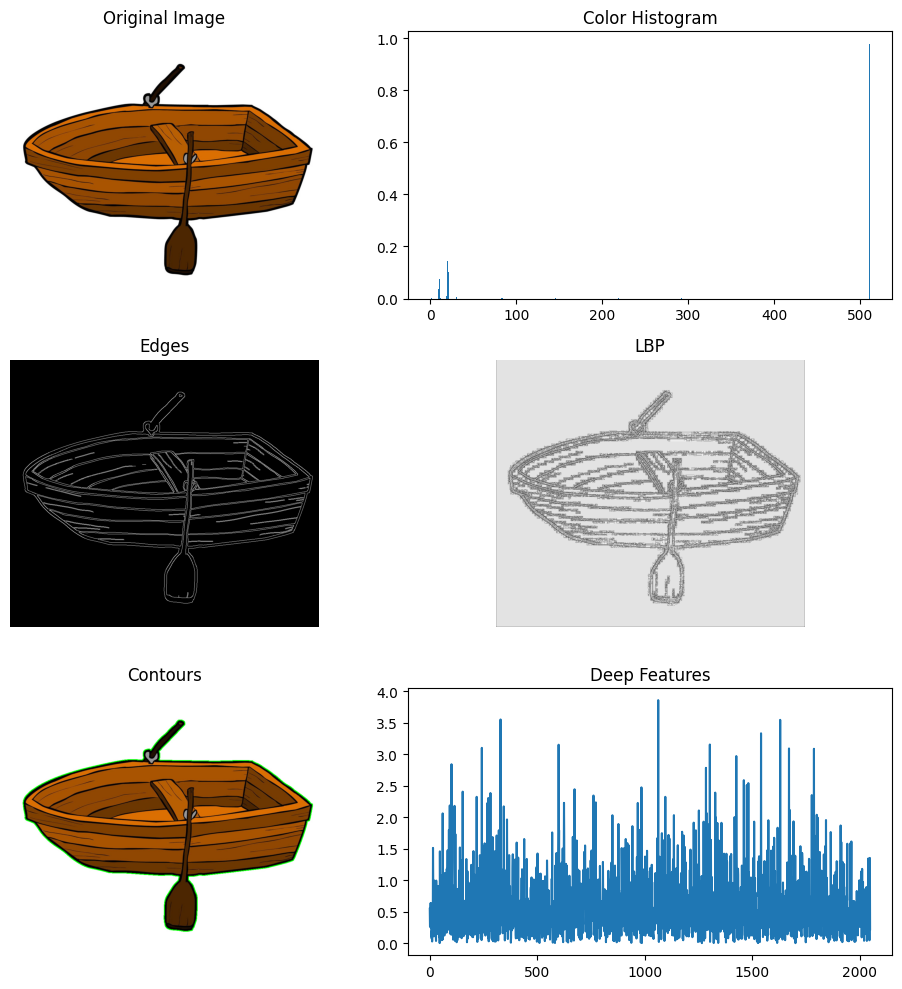

In [40]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()

axes[0].set_title('Original Image')
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].axis('off')

axes[1].set_title('Color Histogram')
axes[1].bar(range(len(color_histogram)), color_histogram)

axes[2].set_title('Edges')
axes[2].imshow(edges, cmap='gray')
axes[2].axis('off')

axes[3].set_title('LBP')
axes[3].imshow(lbp, cmap='gray')
axes[3].axis('off')

axes[4].set_title('Contours')
axes[4].imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
axes[4].axis('off')

axes[5].set_title('Deep Features')
axes[5].plot(deep_features_np.flatten())

plt.tight_layout()
plt.show()